In [5]:
import os
import glob

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from utils.util import preprocessing, order_points
from dotenv import load_dotenv

"""
LOAD CONFIGURATIONS FROM .env FILE
"""
load_dotenv()

TRAIN_DATASET_CONNECT_PATH = f'{os.getcwd()}/{os.getenv("TRAIN_DATASET_CONNECT_PATH")}'

## Qwirkle Connect
*This Jupyter Notebook presents the work done by Vrinceanu Radu-Tudor (group 407 - Artificial Intelligence) for the Computer Vision subject.*

First step that I want to do is to import configs from the ```load_dotenv``` option that populates inside the Jupyter's Notebook runtime environment variables. After that we want to take each game image (load aprox. 21 images in memory 20 - which represents the whole game + 1 starting image). The starting image will represent the point for the "wrapping" algorithm that can center the board and remove translations or rotations. I also want to do for the first image (i.e. the starting one) the extraction of the board from the background by converting the image into an HSV color space and use some thresholds to obtain a mask that can be used in the retrieval of the board itself.

### First chapter of the adventure
**Extract just the boardgame from the starting image from the mask**

I know that each image of type ```g_00.jpg``` where $g = [1, 5]$ and g is a natural number. I define the function ```extract_boardgame_from_starting_image``` I will take the low and high threshold of hsv values to remove the surface on which the boardgame is placed. After that the Canny function will be used to fetch the edges and also determine the biggest polygon that can be build using the contour with the maximum area. This works because after applying the ```bitwise_and``` with the mask the remaining image will have a black background (i.e. dead pixels).

In [6]:
def extract_boardgame_from_starting_image(game_id, path_to_dataset=TRAIN_DATASET_CONNECT_PATH):    
    first_image_path = os.path.join(path_to_dataset, f"{game_id}_00.jpg")
    first_image = cv.imread(first_image_path, cv.IMREAD_COLOR_BGR)
    first_image = cv.resize(first_image, None, fx=0.2, fy=0.2)
    
    first_image_preprocessing = preprocessing(first_image) # get rid of textures by using median blur filters (texture can bring up noise in corner detection)
    
    hsv_threshold_low, hsv_threshold_high = (20, 0, 0), (255, 255, 255)
    hsv_first_image_preprocessing = cv.cvtColor(first_image_preprocessing, cv.COLOR_BGR2HSV)
    board_mask = cv.inRange(hsv_first_image_preprocessing, hsv_threshold_low, hsv_threshold_high)
    
    first_board_image = cv.bitwise_and(first_image, first_image, mask=board_mask)
    
    edges = cv.Canny(first_board_image, 150, 250)
    contours, _ = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # cv.drawContours(first_board_image, contours, -1, (0, 255, 0), 1)
    
    maximum_contour_area, best_contour_idx = 0.0, 0
    for (idx, contour) in enumerate(contours):
        area = cv.contourArea(contour)
        if area > maximum_contour_area:
            best_contour_idx = idx
            maximum_contour_area = area
    
    contour = contours[best_contour_idx]
    perimeter = cv.arcLength(contour, True)
    corners = cv.approxPolyDP(contour, 0.01 * perimeter, True)
    corners = order_points(corners) # @TODO refactor this code from this
    # cv.drawContours(first_board_image, [corners], -1, (0, 255, 0), 1)
    
    height, width = 540, 540
    warp_to = np.array([[0, 0], [width, 0], [0, height], [width, height]]).astype(np.float32)
    perspective_matrix = cv.getPerspectiveTransform(corners.astype(np.float32), warp_to)
            
    return cv.warpPerspective(first_image, perspective_matrix, dsize = (width, height))

warp = extract_boardgame_from_starting_image(1)

### Second chapter of the adventure
**Extract the boardgame information (bonus points) and create a boardgame state**

Maybe Template matching on patches

### Third chapter of the adventure
**Game phase, wrap the game image to the ```g_00.jpg```**

For this we will use a variant of SIFT descriptors which are called ORB descriptors (which represents a faster variant to SIFT descriptors and a newer algorithm). The resource that helped me understand those feature can be found here: https://www.youtube.com/watch?v=_o6fSMCmNnQ


In [34]:
def warp_image_to_starting_image(image_name, starting_game_image, path_to_dataset=TRAIN_DATASET_CONNECT_PATH):
    game_image_path = os.path.join(path_to_dataset, image_name)
    game_image = cv.imread(game_image_path, cv.IMREAD_COLOR_BGR)
    game_image = cv.resize(game_image, None, fx=0.2, fy=0.2)
    
    gray_starting_game_image = cv.cvtColor(starting_game_image, cv.COLOR_BGR2GRAY)
    gray_game_image = cv.cvtColor(game_image, cv.COLOR_BGR2GRAY)
    
    MAX_NUM_OBSERVATIONS = 500
    orb = cv.ORB_create(MAX_NUM_OBSERVATIONS)
    keypoints_starting_game_image, description_starting_game_image = orb.detectAndCompute(gray_starting_game_image, None)
    keypoints_game_image, description_game_image = orb.detectAndCompute(gray_game_image, None)
    
    starting_game_display_image = cv.drawKeypoints(starting_game_image, keypoints_starting_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    game_display_image = cv.drawKeypoints(game_image, keypoints_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.figure(figsize=[20, 10])
    plt.subplot(121); plt.axis('off'); plt.imshow(starting_game_display_image); plt.title('Starting image')
    plt.subplot(122); plt.axis('off'); plt.imshow(game_display_image); plt.title('Game image')
    
    """
    Compute the matches and extract them and discard p% of bad matches
    """
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(description_starting_game_image, description_game_image, None)
    matches = sorted(matches, key=lambda x: x.distance)
    
    matches = matches[:int(len(matches) * 0.1)]
    
    display_matches_image = cv.drawMatches(starting_game_image, keypoints_starting_game_image, game_image, keypoints_game_image, matches, None)
    plt.figure(figsize=[40, 10])
    plt.axis('off'); plt.imshow(display_matches_image); plt.title('Matches')
    
    """
    Compute homography matrix
    """
    points_starting_game_image = np.zeros((len(matches), 2), dtype=np.float32)
    points_game_image = np.zeros((len(matches), 2), dtype=np.float32)
    
    for (i, match) in enumerate(matches):
        points_starting_game_image[i, :] = keypoints_starting_game_image[match.queryIdx].pt
        points_game_image[i, :] = keypoints_game_image[match.trainIdx].pt
        
    h, _ = cv.findHomography(points_game_image, points_starting_game_image, cv.RANSAC)
    
    height, width, _ = starting_game_image.shape
    warped_image = cv.warpPerspective(game_image, h, (width, height))
    
    plt.figure(figsize=[20, 10])
    plt.subplot(121); plt.axis('off'); plt.imshow(starting_game_image); plt.title('Starting image')
    plt.subplot(122); plt.axis('off'); plt.imshow(warped_image); plt.title('Game image - Warped')
    
    return warped_image
    

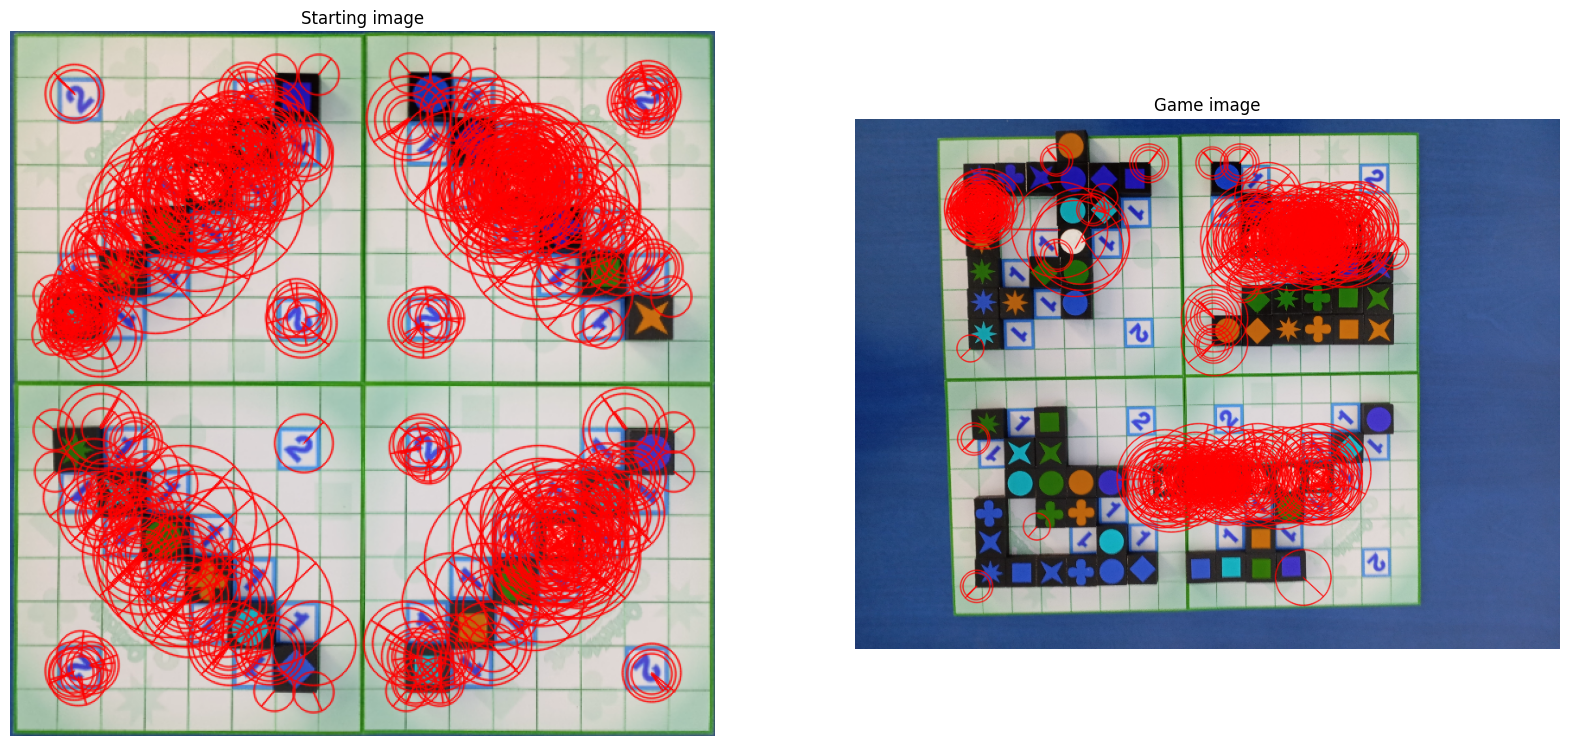

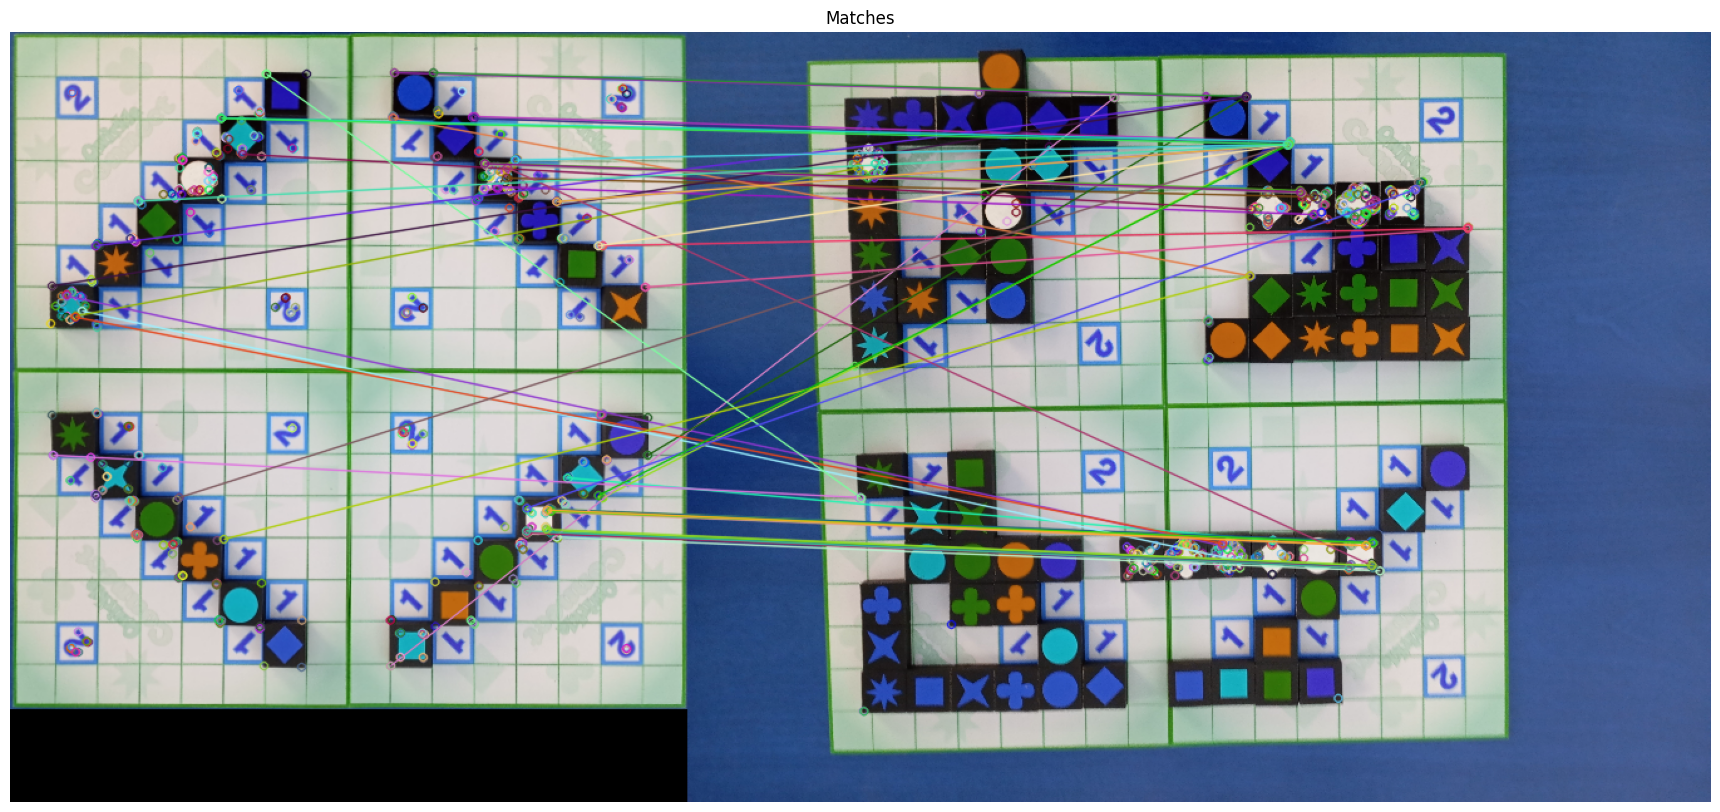

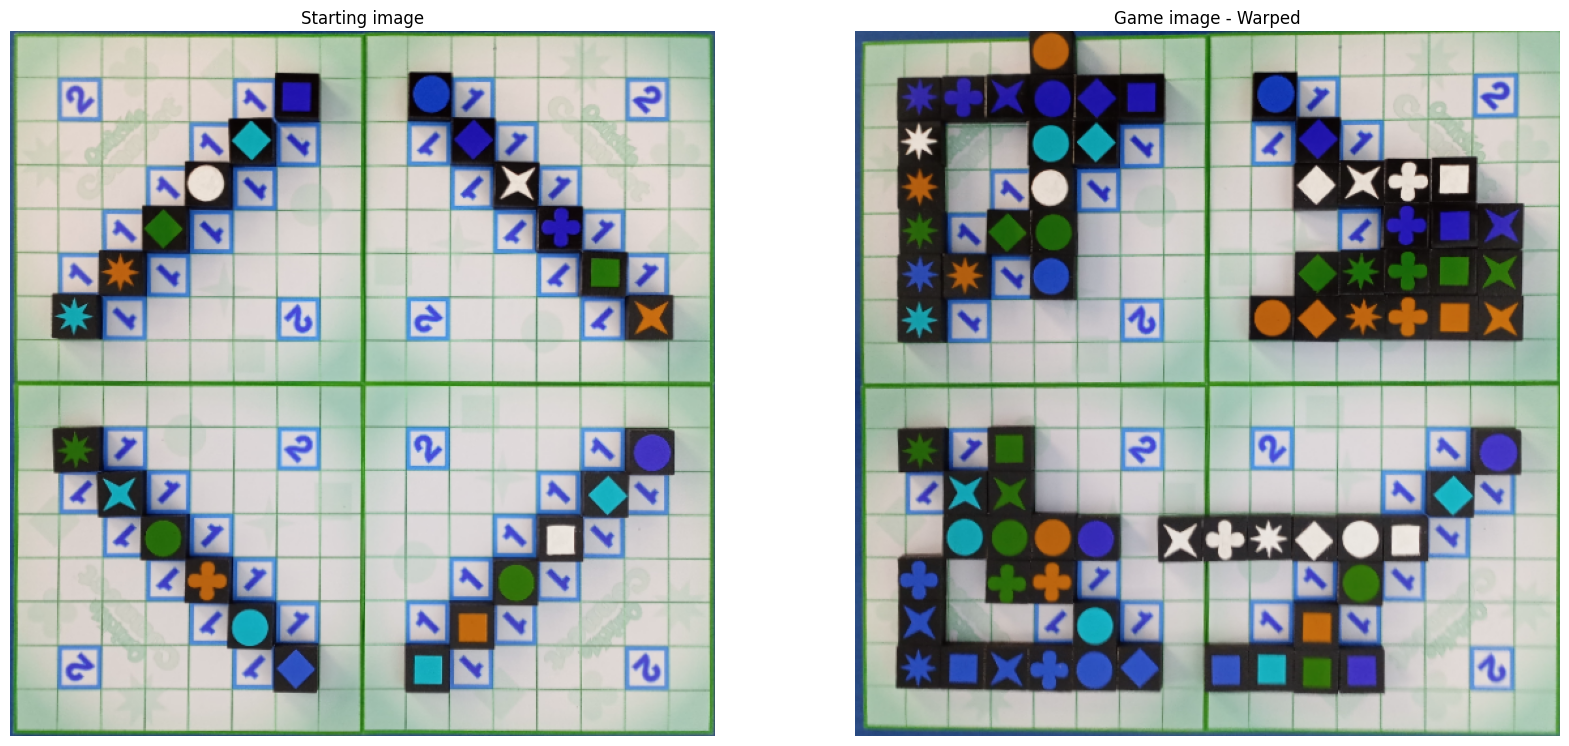

In [36]:
image = warp_image_to_starting_image("1_18.jpg", warp)